In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Training a Classifier

This is it. You have seen how to define neural networks, compute a loss and make
updates to the weights of the network.

Now you might be thinking - **what about data?**

Generally, when you have to deal with image, text, audio or video data,
you can use standard Python packages that load data into a NumPy array.
Then you can convert this array into a ``torch.Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for computer vision, there is a package called ``torchvision``, that provides out-of-the-box data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc (see ``torchvision.datasets`` ).
Furthermore, ``torchvision`` also provides a set of data transformations that are relevant for image processing. This provides a major convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e., 3-channel color images of 32x32 pixels in size.

![Cifar10](imgs/cifar10.png)


## Training an image classifier

We will do the following steps:

1. Load and normalize the CIFAR10 training and test datasets using ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Load and normalize CIFAR10

Using ``torchvision``, it’s straightforward to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1].
# Transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%
/Users/marbetschar/Development/zhaw/MLOps_Labs/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Let us show some of the training images, for fun.



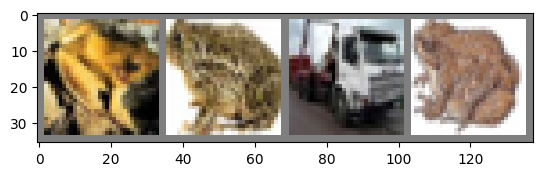

frog  frog  truck frog 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:
for epoch in range(2):  # loop over the dataset multiple times
    print(f"\nStarting epoch {epoch + 1}...")

    running_loss = 0.0
    total_batches = len(trainloader)

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()

        # print statistics every 2000 mini-batches or at end
        if (i + 1) % 2000 == 0 or (i + 1) == total_batches:
            print(
                f"Epoch [{epoch + 1}/2], Batch [{i + 1}/{total_batches}], "
                f"Loss: {running_loss / min(2000, i + 1):.3f}"
            )
            running_loss = 0.0

print('\nFinished Training')


Starting epoch 1...
Epoch [1/2], Batch [2000/12500], Loss: 2.201
Epoch [1/2], Batch [4000/12500], Loss: 1.902
Epoch [1/2], Batch [6000/12500], Loss: 1.680
Epoch [1/2], Batch [8000/12500], Loss: 1.587
Epoch [1/2], Batch [10000/12500], Loss: 1.511
Epoch [1/2], Batch [12000/12500], Loss: 1.434
Epoch [1/2], Batch [12500/12500], Loss: 0.353

Starting epoch 2...
Epoch [2/2], Batch [2000/12500], Loss: 1.367
Epoch [2/2], Batch [4000/12500], Loss: 1.324
Epoch [2/2], Batch [6000/12500], Loss: 1.312
Epoch [2/2], Batch [8000/12500], Loss: 1.324
Epoch [2/2], Batch [10000/12500], Loss: 1.283
Epoch [2/2], Batch [12000/12500], Loss: 1.258
Epoch [2/2], Batch [12500/12500], Loss: 0.317

Finished Training


Let's quickly save our trained model:



In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html)
for more details on saving PyTorch models.

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



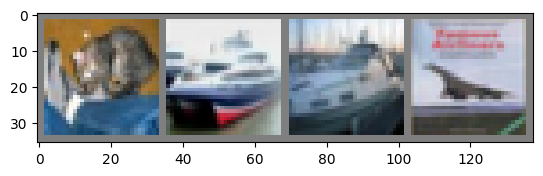

GroundTruth:  cat   ship  ship  plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Now let us see what the neural network thinks these examples above are:



In [12]:
outputs = net(images)
print(outputs)

tensor([[ 0.1806, -2.9010,  2.5051,  3.1566,  0.1208,  1.7238,  1.9644, -1.8842,
         -1.0821, -2.7462],
        [ 7.1612,  6.6033, -0.8901, -3.3291, -3.7196, -5.5761, -5.6194, -3.9773,
          9.0675,  3.9206],
        [ 3.4806,  3.6448, -0.5607, -1.2143, -2.5222, -2.8670, -2.4739, -2.7735,
          5.4445,  2.0326],
        [ 5.4049,  1.6170,  1.7409, -1.3672, -2.3279, -3.9324, -0.7352, -4.2419,
          5.2020, -0.1100]], grad_fn=<AddmmBackward0>)


The raw outputs are probabilities for the 10 classes.
The higher the probabilities for a class, the more the network
thinks that the image is of the particular class.
So, let's check the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Do the results make sense?
- If not, you might want to train a few additional epochs?!
- If yes, let us look at how the network performs on the whole dataset.



In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


How did this perform?
What accuracy would you expect if the model were just to output random values? Is our model better than random?

### Looking at this a bit deeper..
What are the classes that performed well and the classes that did
not perform well?

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 67.7 %
Accuracy for class: car   is 65.6 %
Accuracy for class: bird  is 45.5 %
Accuracy for class: cat   is 40.9 %
Accuracy for class: deer  is 41.8 %
Accuracy for class: dog   is 43.5 %
Accuracy for class: frog  is 83.4 %
Accuracy for class: horse is 51.7 %
Accuracy for class: ship  is 67.1 %
Accuracy for class: truck is 55.9 %


Okay, so what next? We might train the model longer.. How can we speed it up?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "mps" if torch.mps.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

mps


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

```python
    net.to(device)
```

Remember that you will have to send the inputs and targets at every step
to the GPU too:

```python
    inputs, labels = data[0].to(device), data[1].to(device)
```

Why don't I notice a MASSIVE speedup compared to CPU? Because your network is really (really, really) small.

## Exercise
Try increasing the width of your network (argument 2 of the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

## Goals achieved
- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images